In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("dark_background")

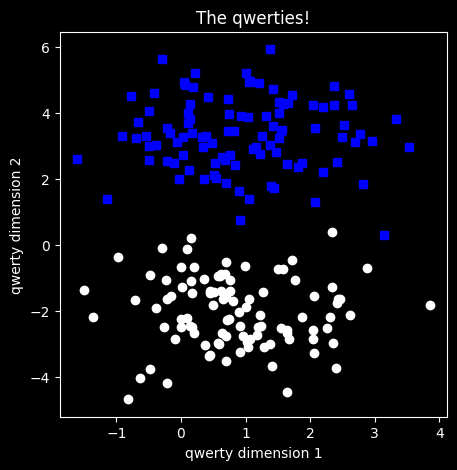

In [ ]:
nPerClust = 100
blur = 1

A = [  1,  3 ]
B = [  1, -2 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'wo')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [ ]:
ANNclassify = nn.Sequential(
      nn.Linear(2,16),  # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(16,1),  # hidden layer
      nn.ReLU(),        # activation unit
      nn.Linear(1,1),   # output unit
      nn.Sigmoid(),     # final activation unit
        )

In [ ]:
class ANNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2, 16)
        self.batchNorm1 = nn.BatchNorm1d(16)
        self.hidden1 = nn.Linear(16, 1)
        self.batchNorm2 = nn.BatchNorm1d(1)
        self.output = nn.Linear(1, 1)

    def forward(self, x, doBN, doBNBef=False):
        x = self.input(x)


        if doBN:
            x = F.relu(x)
            x = self.batchNorm1(x)
            x = self.hidden1(x)
            x = F.relu( x )

            x = self.batchNorm2(x)
            x = self.output(x)
        elif doBNBef:
            x = self.batchNorm1(x)
            x = F.relu(x)

            x = self.hidden1(x)
            x = self.batchNorm2(x)
            x = F.relu(x)
            x = self.output(x)
        else:
            x = F.relu(x)
            x = self.hidden1(x)
            x = F.relu( x )

        x = self.output(x)
        x = torch.sigmoid( x )

        return x

In [ ]:
modelForTesting = ANNClassifier()
randomSample = torch.randn(10, 2)
testPred = modelForTesting(randomSample, doBN=True)
testPred

tensor([[0.4769],
        [0.8323],
        [0.8738],
        [0.4769],
        [0.4769],
        [0.7689],
        [0.5284],
        [0.4769],
        [0.4769],
        [0.4769]], grad_fn=<SigmoidBackward0>)

In [ ]:
data.shape

torch.Size([200, 2])

In [ ]:
modelForTesting

ANNClassifier(
  (input): Linear(in_features=2, out_features=16, bias=True)
  (batchNorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1): Linear(in_features=16, out_features=1, bias=True)
  (batchNorm2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
def testModel(model: nn.Module, doBN=True, doBNBef=False, epochs=200):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    losses = []
    accs   = []

    for i in range(epochs):
        y_pred = model(data, doBN, doBNBef)
        loss = criterion(y_pred, labels)
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # y_pred = model(data)
        matches = (y_pred > 0.5) == labels
        acc = torch.mean(matches.float()) * 100
        accs.append(acc)

    return losses, accs

In [ ]:
model = ANNClassifier()
lossesNormed, accsNormed = testModel(model, doBN=True)
losses, accs = testModel(model, doBN=False)
lossesBef, accsBef = testModel(model, doBN=False, doBNBef=True)

* As you can see, it is even better if we applied BatchNorm before forward pass to activation function.

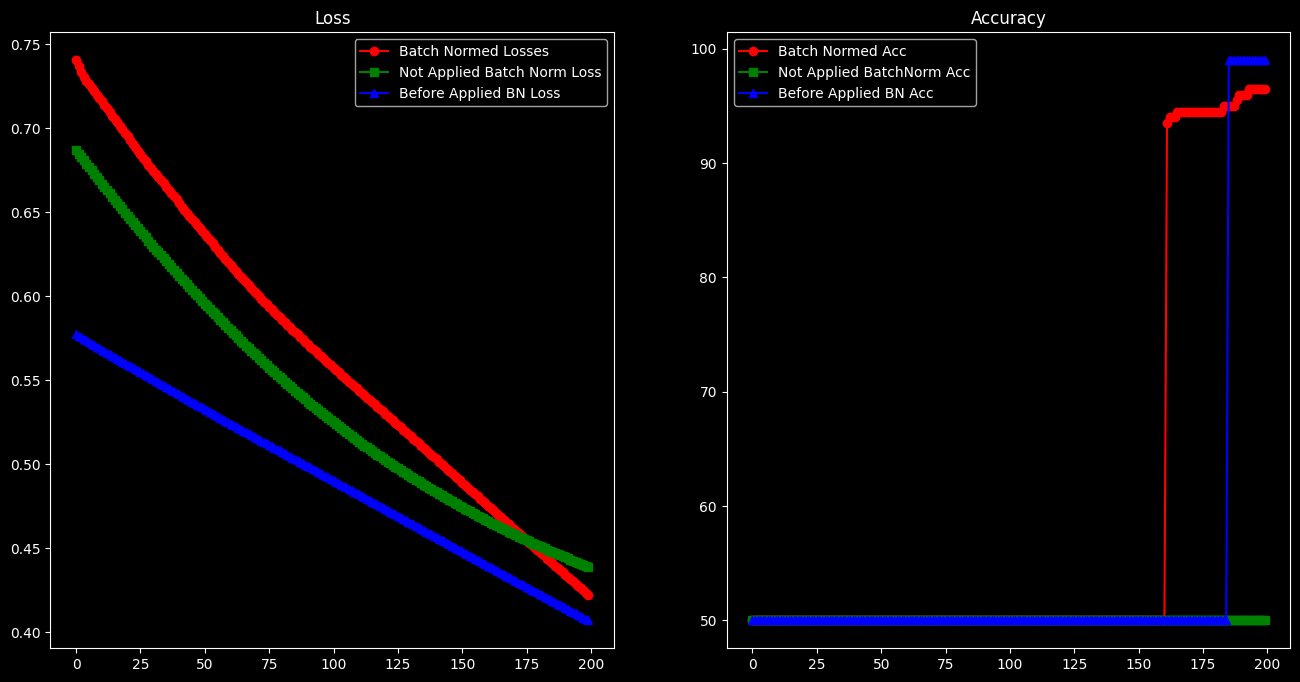

In [ ]:
with torch.no_grad():
    fig = plt.figure(figsize=(16, 8))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)

    ax0.set_title("Loss")
    ax0.plot(lossesNormed, "ro-", label="Batch Normed Losses")
    ax0.plot(losses, "gs-", label="Not Applied Batch Norm Loss")
    ax0.plot(lossesBef, "b^-", label="Before Applied BN Loss")
    ax0.legend()

    ax1.set_title("Accuracy")
    ax1.plot(accsNormed, "ro-", label="Batch Normed Acc")
    ax1.plot(accs, "gs-", label="Not Applied BatchNorm Acc")
    ax1.plot(accsBef, "b^-", label="Before Applied BN Acc")
    ax1.legend()